In [1]:
import collections
import os
import json
import logging

import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.alphabet import ALPHABET_DNA
from rna_learn.load_sequences import (
    load_growth_temperatures, 
    compute_inverse_effective_sample,
    assign_weight_to_batch_values,
    SpeciesSequence,
    load_batch_dataframe,
)
from rna_learn.transform import sequence_embedding, normalize, denormalize
from rna_learn.model import conv1d_densenet_regression_model, compile_regression_model, DenormalizedMAE
from rna_learn.int_grads import (
    integrated_gradients_for_binary_features,
    make_gradient_fn,
)
from rna_learn.fourier import compute_autocorr_fft

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()
logging.basicConfig(level=logging.INFO, format="%(asctime)s (%(levelname)s) %(message)s")

## Load Model

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

In [4]:
run_id = 'run_yb64o'
model_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/model.h5')
metadata_path = os.path.join(os.getcwd(), f'saved_models/{run_id}/metadata.json')
validation_csv = os.path.join(os.getcwd(), f'saved_models/{run_id}/validation.csv')

In [5]:
val_df = pd.read_csv(validation_csv).set_index('species_taxid')
val_df.head(2)

,growth_tmp_actual,growth_tmp_prediction,growth_tmp_std
species_taxid,,,
7,30.00,36.67,15.47
14,74.15,62.08,24.86


In [6]:
with open(metadata_path) as f:
    metadata = json.load(f)

In [7]:
model = conv1d_densenet_regression_model(
    alphabet_size=len(metadata['alphabet']), 
    growth_rate=metadata['growth_rate'],
    n_layers=metadata['n_layers'],
    kernel_sizes=metadata['kernel_sizes'],
    dilation_rates=metadata['dilation_rates'],
    l2_reg=metadata['l2_reg'],
    dropout=metadata['dropout'],
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 15)     195         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 19)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 15)     1440        concat_1[0][0]        

In [8]:
model.load_weights(model_path)

## Load growth temperature data

In [9]:
temperatures, mean, std = load_growth_temperatures(engine)

In [10]:
species_traits_query = """
select * from species_traits where species_taxid in (
    select species_taxid from train_test_split
    where in_test_set = 1
)
"""
species_traits = pd.read_sql(species_traits_query, engine)
species_traits.head(2)

,species_taxid,species,genus,family,order,class,phylum,superkingdom,gram_stain,metabolism,...,genome_size.stdev,gc_content.stdev,coding_genes.stdev,optimum_tmp.stdev,optimum_ph.stdev,growth_tmp.stdev,rRNA16S_genes.stdev,tRNA_genes.stdev,data_source,ref_id
0,7,Azorhizobium caulinodans,Azorhizobium,Xanthobacteraceae,Rhizobiales,Alphaproteobacteria,Proteobacteria,Bacteria,negative,aerobic,...,1.000,NaN,7.572,NaN,NaN,NaN,0.0,0.0,"engqvist, genbank, gold, jemma-refseq, kegg, p...","705, 6102, 13521, 13643, 15838, 19908, 19956"
1,14,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,Dictyoglomia,Dictyoglomi,Bacteria,negative,anaerobic,...,1.342,0.0,31.086,0.0,NaN,5.869,0.0,0.0,"corkrey, engqvist, genbank, gold, jemma-refseq...","436, 705, 6230, 13521, 14083, 16003, 19891, 19..."


In [11]:
species_traits[species_traits['growth_tmp'] == 37].head(2)

,species_taxid,species,genus,family,order,class,phylum,superkingdom,gram_stain,metabolism,...,genome_size.stdev,gc_content.stdev,coding_genes.stdev,optimum_tmp.stdev,optimum_ph.stdev,growth_tmp.stdev,rRNA16S_genes.stdev,tRNA_genes.stdev,data_source,ref_id
9,167,Treponema succinifaciens,Treponema,Spirochaetaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,negative,anaerobic,...,2.236,0.284,37.873,NaN,NaN,NaN,0.0,0.000,"engqvist, faprotax, genbank, gold, jemma-refse...","705, 999, 6514, 13521, 15182, 16567, 19891, 19..."
10,196,Campylobacter fetus,Campylobacter,Campylobacteraceae,Campylobacterales,Epsilonproteobacteria,Proteobacteria,Bacteria,negative,microaerophilic,...,102299.821,0.766,124.603,0.0,NaN,NaN,0.0,1.477,"bacdive-microa, engqvist, genbank, gold, jemma...","151, 705, 5660, 9060, 9205, 9820, 9954, 10274,..."


## Load sequences from a single specie

In [12]:
query = """
select t.species, s.sequence, s.length, t.growth_tmp
from sequences as s
inner join species_traits as t
on t.species_taxid = s.species_taxid
where s.species_taxid = ?
"""
species_taxid = 167
species_df = pd.read_sql(query, engine, params=(species_taxid,))

species = species_df['species'].iloc[0]
actual_tmp = species_df['growth_tmp'].iloc[0]
species, actual_tmp

('Treponema succinifaciens', 37.0)

In [13]:
val_df.loc[species_taxid]

growth_tmp_actual        37.00
growth_tmp_prediction    42.41
growth_tmp_std           20.00
Name: 167, dtype: float64

In [14]:
len(species_df)

3820

In [15]:
max_sequence_length = 9999  # divisible by 3
species_seq = SpeciesSequence(
    engine, 
    species_taxid=species_taxid,
    batch_size=64, 
    temperatures=temperatures,
    mean=mean,
    std=std,
    alphabet=ALPHABET_DNA, 
    max_sequence_length=max_sequence_length,
    random_seed=metadata['seed'],
)

In [16]:
def load_sequence_row(rowid):
    q = """
    select * from sequences where rowid = ?
    """
    return pd.read_sql(q, engine, params=(int(rowid),)).iloc[0]

## Integrated Gradients

In [17]:
gradient_fn = make_gradient_fn(model)

In [18]:
batch_x, _, _ = species_seq[0]

inputs = batch_x[0:10]
baseline = np.ones(inputs[0].shape)
target = actual_tmp

attributions = integrated_gradients_for_binary_features(
    inputs,
    baseline,
    target,
    gradient_fn
)
attributions.shape

(10, 999)

In [19]:
sequence_row = load_sequence_row(species_seq.rowids[0,0])
length = sequence_row.length
sequence_row

sequence_id                     lcl|CP002631.1_cds_AEB15151.1_2181
species_taxid                                                  167
sequence_type                                                  CDS
chromosome_id                                           CP002631.1
location_json                                 [[2439987, 2440718]]
strand                                                           +
length                                                         732
description      lcl|CP002631.1_cds_AEB15151.1_2181 [locus_tag=...
metadata_json    {"protein": "uridylate kinase", "protein_id": ...
sequence         ATGACTACAAAAGTTTTAAGCGTAGGCGGTTCAATAATTGCGCCTG...
Name: 0, dtype: object

In [20]:
sequence_row.metadata_json

'{"protein": "uridylate kinase", "protein_id": "AEB15151.1"}'

In [21]:
attributions = attributions[0, :length]

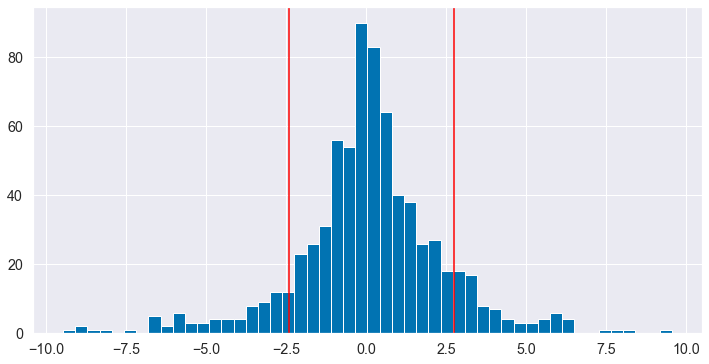

In [22]:
percentile = 90
threshold = np.percentile(attributions, percentile)
inv_threshold = np.percentile(attributions, 100 - percentile)

_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(attributions, bins=50);
ax.axvline(threshold, color='red');
ax.axvline(inv_threshold, color='red');

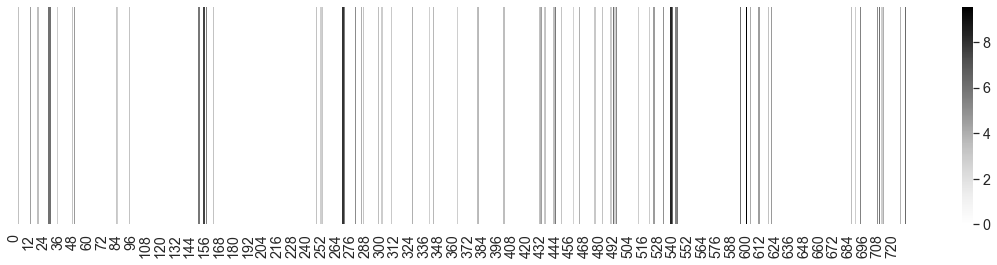

In [23]:
attributions_c = attributions.copy()
threshold_indices = attributions_c < threshold
attributions_c[threshold_indices] = 0

_, ax = plt.subplots(1, 1, figsize=(20, 4))
sns.heatmap(attributions_c[np.newaxis,:length], vmin=0, ax=ax, cmap='Greys');
ax.get_yaxis().set_visible(False);

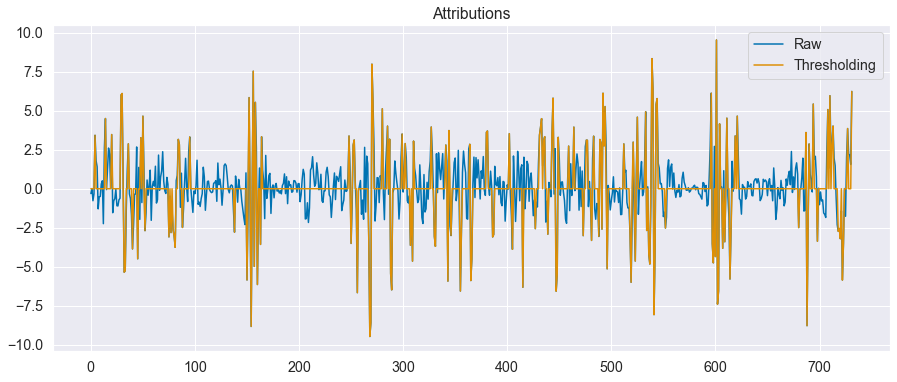

In [24]:
attributions_ = attributions.copy()
threshold_ix = attributions_ < threshold
inv_threshold_ix = attributions_ > inv_threshold
attributions_[threshold_ix & inv_threshold_ix] = 0

_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(range(length), attributions, '-', label='Raw');
ax.plot(range(length), attributions_, '-', label='Thresholding');
ax.set_title('Attributions');
ax.legend();

## Apply fourier transform

In [25]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2 + 1:]

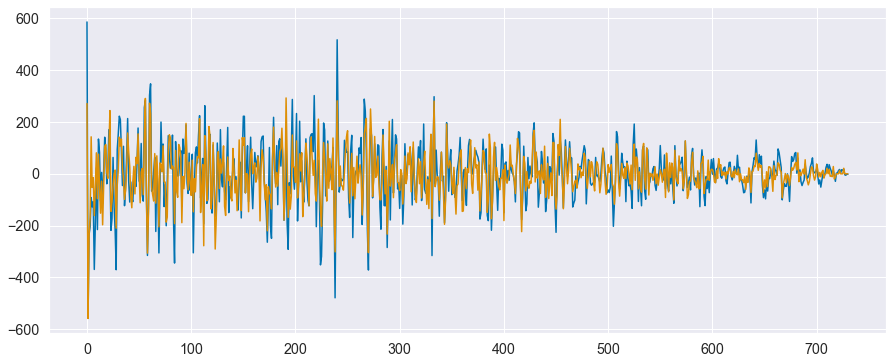

In [26]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
attr_autocorr = autocorr(attributions)
ax.plot(range(len(attr_autocorr)), attr_autocorr);

attr_autocorr_ = autocorr(attributions_)
ax.plot(range(len(attr_autocorr_)), attr_autocorr_);

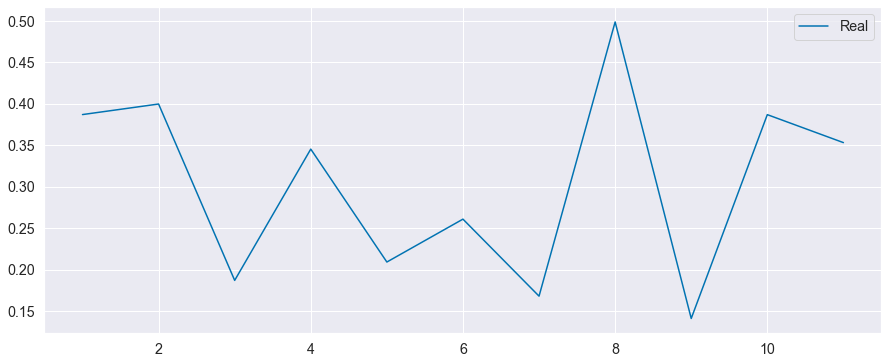

In [27]:
ft = np.fft.rfft(attr_autocorr, n=20, norm='ortho')
ft_real = np.abs(ft)
ft_imag = np.imag(ft)

_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(range(1, len(ft) + 1), ft_real / length, label='Real');
#ax.plot(range(1, len(ft) + 1), ft_imag / length, label='Imag');
ax.legend();

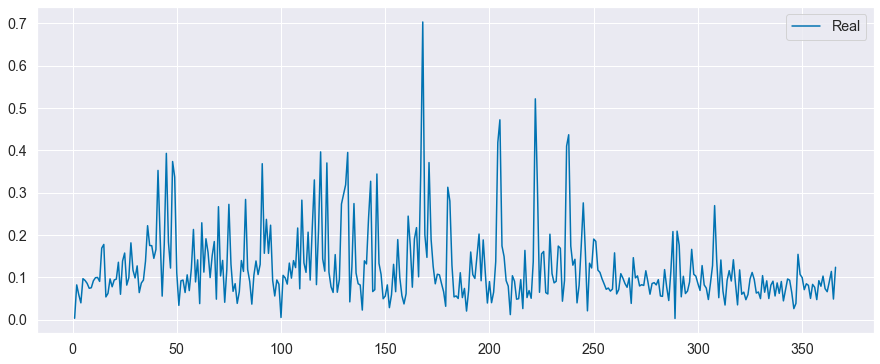

In [28]:
ft = np.fft.rfft(attr_autocorr, norm='ortho')
ft_real = np.abs(ft)
ft_imag = np.imag(ft)

_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(range(1, len(ft) + 1), ft_real / length, label='Real');
#ax.plot(range(1, len(ft) + 1), ft_imag / length, label='Imag');
ax.legend();

In [43]:
(np.argsort(-np.abs(ft)) + 1)[:10]

array([168, 222, 205, 238, 204, 237, 119, 132,  45,  48])

## Compute attribution and FFT on all the sequence of this specie

In [30]:
def compute_attributions_and_fft(species_seq, actual_tmp, gradient_fn, n=200):
    all_attributions = []
    all_ffts = []
    
    max_length = species_seq.max_sequence_length
    for i in range(len(species_seq)):
        if (i + 1) % 10 == 0:
            print(f'Batch {i+1} / {len(species_seq)}')
            
        batch_x, _, _ = species_seq[i]
        
        baseline = np.ones(batch_x[0].shape)
        target = actual_tmp

        attributions = integrated_gradients_for_binary_features(
            batch_x,
            baseline,
            target,
            gradient_fn
        )
        
        a = i * species_seq.batch_size
        b = (i + 1) * species_seq.batch_size
        batch_rowids = species_seq.rowids[a:b]
        
        batch_df = load_batch_dataframe(species_seq.engine, batch_rowids[:, 0])
        
        for j, seq_attribution_padded in enumerate(attributions):
            rowid, part_ix = batch_rowids[j]
            length = int(batch_df.loc[rowid]['length'])
            if length > max_length:
                a = part_ix * max_length
                b = (part_ix + 1) * max_length
                if b > length:
                    length = length - part_ix * max_length
                else:
                    length = max_length
                
            seq_attribution = seq_attribution_padded[:length]
            
            percentile = 90
            threshold = np.percentile(seq_attribution, percentile)
            inv_threshold = np.percentile(seq_attribution, 100 - percentile)
            
            seq_attribution_ = seq_attribution.copy()
            threshold_ix = seq_attribution < threshold
            inv_threshold_ix = seq_attribution > inv_threshold
            seq_attribution_[threshold_ix & inv_threshold_ix] = 0
            
            real_fft = compute_autocorr_fft(seq_attribution, n=None)
            all_ffts.append(real_fft[:n // 2])
            
    return all_attributions, all_ffts

In [31]:
#%%time
#all_attributions, all_ffts = compute_attributions_and_fft(species_seq, actual_tmp, gradient_fn, n=200)

In [32]:
#best_freqs = [np.argmax(fft) + 1 for fft in all_ffts]
#plt.hist(best_freqs, bins=100);

In [33]:
#mean_fft = np.mean(all_ffts, axis=0)
#
#_, ax = plt.subplots(1, 1, figsize=(15, 6))
#ax.plot(range(1, len(mean_fft) + 1), mean_fft, 'o');

## Distribution of attribution per codon in CDS

In [34]:
def compute_attributions_per_codon(species_seq, actual_tmp, gradient_fn):
    attributions_per_codon = collections.defaultdict(list)
    
    max_length = species_seq.max_sequence_length
    for i in range(len(species_seq)):
        if (i + 1) % 10 == 0:
            print(f'Batch {i+1} / {len(species_seq)}')
            
        batch_x, _, _ = species_seq[i]
        
        baseline = np.ones(batch_x[0].shape)
        target = actual_tmp

        attributions = integrated_gradients_for_binary_features(
            batch_x,
            baseline,
            target,
            gradient_fn
        )
        
        a = i * species_seq.batch_size
        b = (i + 1) * species_seq.batch_size
        batch_rowids = species_seq.rowids[a:b]
        
        batch_df = load_batch_dataframe(species_seq.engine, batch_rowids[:, 0])
        
        for j, seq_attribution_padded in enumerate(attributions):
            rowid, part_ix = batch_rowids[j]
            seq_metadata = batch_df.loc[rowid]
            sequence_full = seq_metadata['sequence']
            length = int(seq_metadata['length'])
            sequence_type = seq_metadata['sequence_type']
            if sequence_type != 'CDS':
                continue
            
            if length > max_length:
                a = part_ix * max_length
                b = (part_ix + 1) * max_length
                if b > length:
                    length = length - part_ix * max_length
                else:
                    length = max_length
            
                sequence = sequence_full[a:b]
            else:
                sequence = sequence_full
                
            seq_attribution = seq_attribution_padded[:length]
            
            assert len(sequence) % 3 == 0
            assert len(sequence) == len(seq_attribution), f"{len(sequence)}, {len(seq_attribution)}, {int(seq_metadata['length'])}"
            
            for codon_start_ix in range(0, len(seq_attribution), 3):
                codon_end_ix = codon_start_ix + 3
                codon = sequence[codon_start_ix:codon_end_ix]
                codon_attr = seq_attribution[codon_start_ix:codon_end_ix]
                attributions_per_codon[codon].append(codon_attr)
                
    for key in attributions_per_codon.keys():
        attributions_per_codon[key] = np.array(attributions_per_codon[key])

    return dict(attributions_per_codon)

In [35]:
%%time
attributions_per_codon = compute_attributions_per_codon(species_seq, actual_tmp, gradient_fn)

Batch 10 / 60
Batch 20 / 60
Batch 30 / 60
Batch 40 / 60
Batch 50 / 60
Batch 60 / 60
CPU times: user 2min 34s, sys: 1min 10s, total: 3min 44s
Wall time: 1min 1s


In [36]:
mean_attribution_per_codon = []
for key in attributions_per_codon.keys():
    attr = attributions_per_codon[key]
    m = np.mean(attr)
    s = np.std(attr)

    cod = [np.round(n, 2) for n in np.mean(attributions_per_codon[key], axis=0)]
    
    mean_attribution_per_codon.append((key, m, s, len(attr), cod))

sorted_mean_attribution_per_codon = sorted(mean_attribution_per_codon, key=lambda t: t[1], reverse=True)
sorted_mean_attribution_per_codon

[('TAG', 7.2052565, 6.759869, 517, [4.66, 9.96, 6.99]),
 ('TGA', 4.608608, 5.7238455, 607, [1.79, 7.51, 4.53]),
 ('TAA', 3.4036243, 4.054894, 1484, [2.6, 2.62, 4.99]),
 ('CTA', 1.3657304, 3.5424414, 3094, [0.82, 2.42, 0.85]),
 ('CTC', 1.2025568, 2.8750193, 4711, [1.91, 1.19, 0.5]),
 ('ATA', 0.9936097, 2.5115368, 16217, [0.35, 0.92, 1.71]),
 ('CCT', 0.57384133, 2.836134, 9925, [0.51, 0.65, 0.56]),
 ('TAC', 0.56220394, 2.2165108, 12051, [0.84, 0.63, 0.21]),
 ('TCT', 0.5613862, 2.5833454, 15786, [0.65, 0.06, 0.97]),
 ('CTT', 0.53105235, 1.9748791, 35552, [0.53, 0.8, 0.26]),
 ('AGG', 0.5281201, 2.0979524, 3593, [0.61, 0.31, 0.67]),
 ('TAT', 0.49388698, 2.5310643, 18963, [1.05, 0.02, 0.41]),
 ('GTA', 0.49023533, 2.741942, 12114, [-0.38, 0.85, 1.0]),
 ('GAG', 0.43473512, 2.0870883, 13878, [0.41, 0.25, 0.64]),
 ('GTT', 0.39161012, 2.4194756, 26912, [-0.2, 0.9, 0.47]),
 ('CCA', 0.33500406, 2.247349, 7306, [0.41, 0.61, -0.02]),
 ('CCC', 0.2877362, 2.3558686, 1459, [0.1, 0.27, 0.49]),
 ('AGA', 0

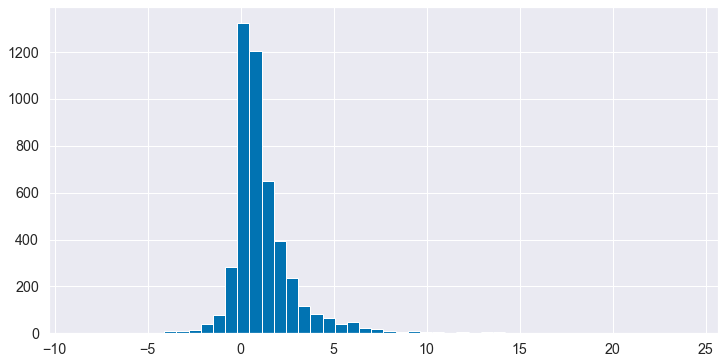

In [37]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(np.mean(attributions_per_codon['CTC'], axis=1), bins=50);

In [38]:
def compute_attributions_per_nucleotide(species_seq, actual_tmp, gradient_fn):
    attributions_per_nucleotide = collections.defaultdict(list)
    at_gc_content = collections.defaultdict(int)
    acgt_set = {'A', 'C', 'G', 'T'}
    gc_set = {'G', 'C'}
    
    max_length = species_seq.max_sequence_length
    for i in range(len(species_seq)):
        if (i + 1) % 10 == 0:
            print(f'Batch {i+1} / {len(species_seq)}')
            
        batch_x, _, _ = species_seq[i]
        
        baseline = np.ones(batch_x[0].shape)
        target = actual_tmp

        attributions = integrated_gradients_for_binary_features(
            batch_x,
            baseline,
            target,
            gradient_fn
        )
        
        a = i * species_seq.batch_size
        b = (i + 1) * species_seq.batch_size
        batch_rowids = species_seq.rowids[a:b]
        
        batch_df = load_batch_dataframe(species_seq.engine, batch_rowids[:, 0])
        
        for j, seq_attribution_padded in enumerate(attributions):
            rowid, part_ix = batch_rowids[j]
            seq_metadata = batch_df.loc[rowid]
            sequence_full = seq_metadata['sequence']
            length = int(seq_metadata['length'])
            sequence_type = seq_metadata['sequence_type']
            
            if length > max_length:
                a = part_ix * max_length
                b = (part_ix + 1) * max_length
                if b > length:
                    length = length - part_ix * max_length
                else:
                    length = max_length
            
                sequence = sequence_full[a:b]
            else:
                sequence = sequence_full
                
            seq_attribution = seq_attribution_padded[:length]
            
            for nucleotide_ix in range(len(seq_attribution)):
                nucleotide = sequence[nucleotide_ix]
                nucleotide_attr = seq_attribution[nucleotide_ix]
                attributions_per_nucleotide[nucleotide].append(nucleotide_attr)
                
                if nucleotide in acgt_set:
                    at_gc_content_key = 'gc' if nucleotide in gc_set else 'at'
                    at_gc_content[at_gc_content_key] += 1
                
    for key in attributions_per_nucleotide.keys():
        attributions_per_nucleotide[key] = np.array(attributions_per_nucleotide[key])
        
    atgc_sum = at_gc_content['gc'] + at_gc_content['at']
    at_gc_content['gc'] = at_gc_content['gc'] / atgc_sum
    at_gc_content['at'] = at_gc_content['at'] / atgc_sum

    return dict(attributions_per_nucleotide), at_gc_content

In [39]:
%%time
attributions_per_nucleotide, at_gc_content = compute_attributions_per_nucleotide(species_seq, actual_tmp, gradient_fn)

Batch 10 / 60
Batch 20 / 60
Batch 30 / 60
Batch 40 / 60
Batch 50 / 60
Batch 60 / 60
CPU times: user 2min 43s, sys: 1min 16s, total: 4min
Wall time: 55.7 s


In [40]:
for nucleotide in sorted(attributions_per_nucleotide.keys()):
    m = np.mean(attributions_per_nucleotide[nucleotide])
    print(nucleotide, f'{m:.2f}')

A 0.09
C -0.10
G -0.18
T 0.29


In [41]:
print('CG', at_gc_content['gc'])
np.mean(np.vstack((
    attributions_per_nucleotide['C'][:, np.newaxis],
    attributions_per_nucleotide['G'][:, np.newaxis],
)))

CG 0.3966550656833543


-0.14277846

In [42]:
print('AT', at_gc_content['at'])
np.mean(np.vstack((
    attributions_per_nucleotide['A'][:, np.newaxis],
    attributions_per_nucleotide['T'][:, np.newaxis],
)))

AT 0.6033449343166457


0.18671049